# SAYCam autocorrelation analysis



Chris Iyer

updated 12/11/24

In [4]:
import os, glob, cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import pickle_save_dict, pickle_load_dict
from video_processing import read_embed_video, plot_frames, get_cropping_dims, concatenate_embeddings_timestamps
from autocorrelation import get_consec_dists, run_plot_acf, get_familiarity_timeseries, plot_acf, plot_consec_dist
# these ^^^ are the important fxns! 

%load_ext autoreload
%autoreload 2

In [5]:
INPUT_DIR = 'videos'
OUTPUT_DIR = 'outputs'
CONCATENATE_ALL = False

DOWNSAMPLED_FR = 3
MODEL_NAME = 'vit' # 'vit' or 'resnet' # respectively, these will make 768-D or 2048-D embeddings
DEVICE = 'cpu' # 'cpu' or 'cuda'
N_JOBS = 1
PERMUTE_N_ITER = 0

## View example frames

CROPPING INFORMATION:

Each video is cropped with a square crop of side length 420 pixels, centered 30 pixels below center.

100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


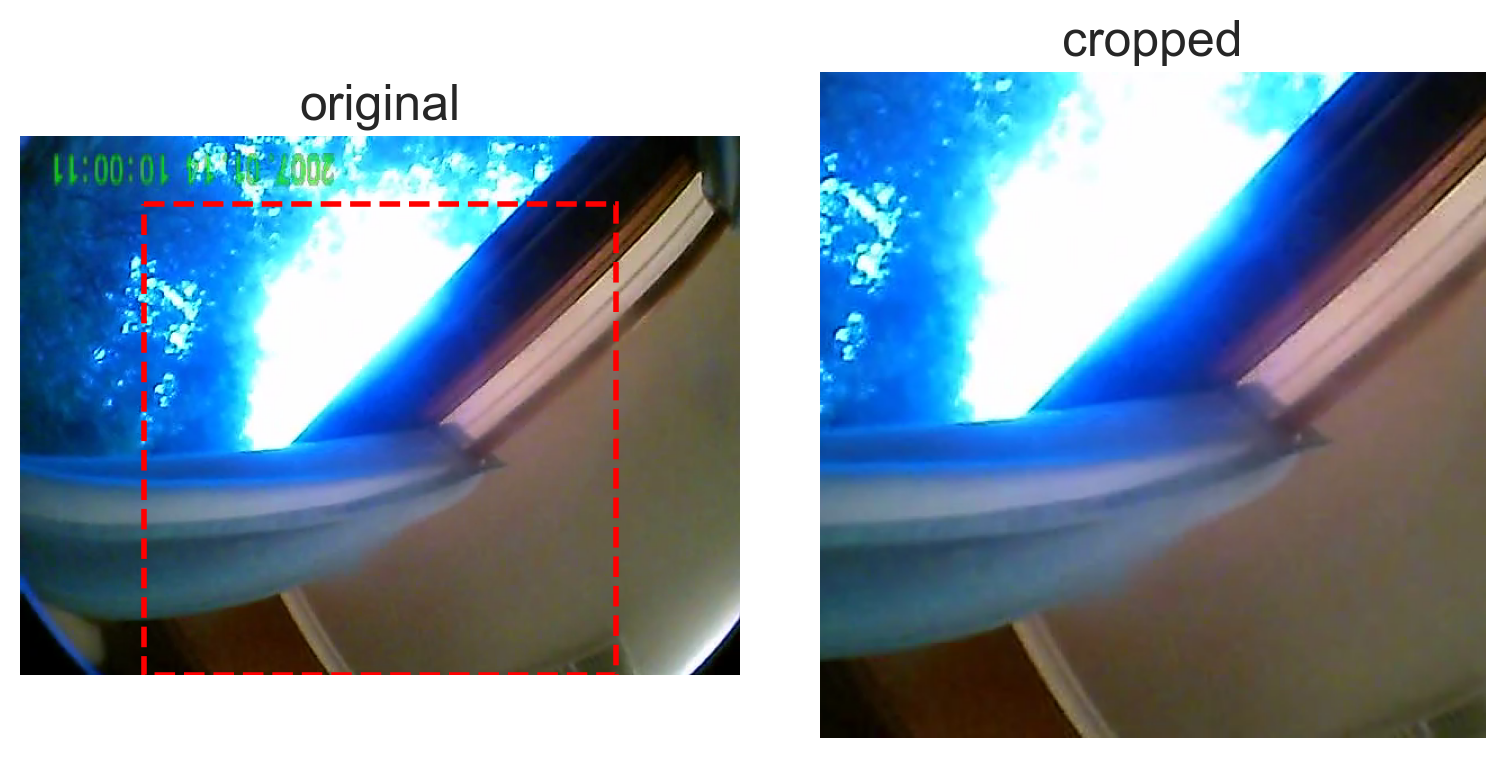

100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


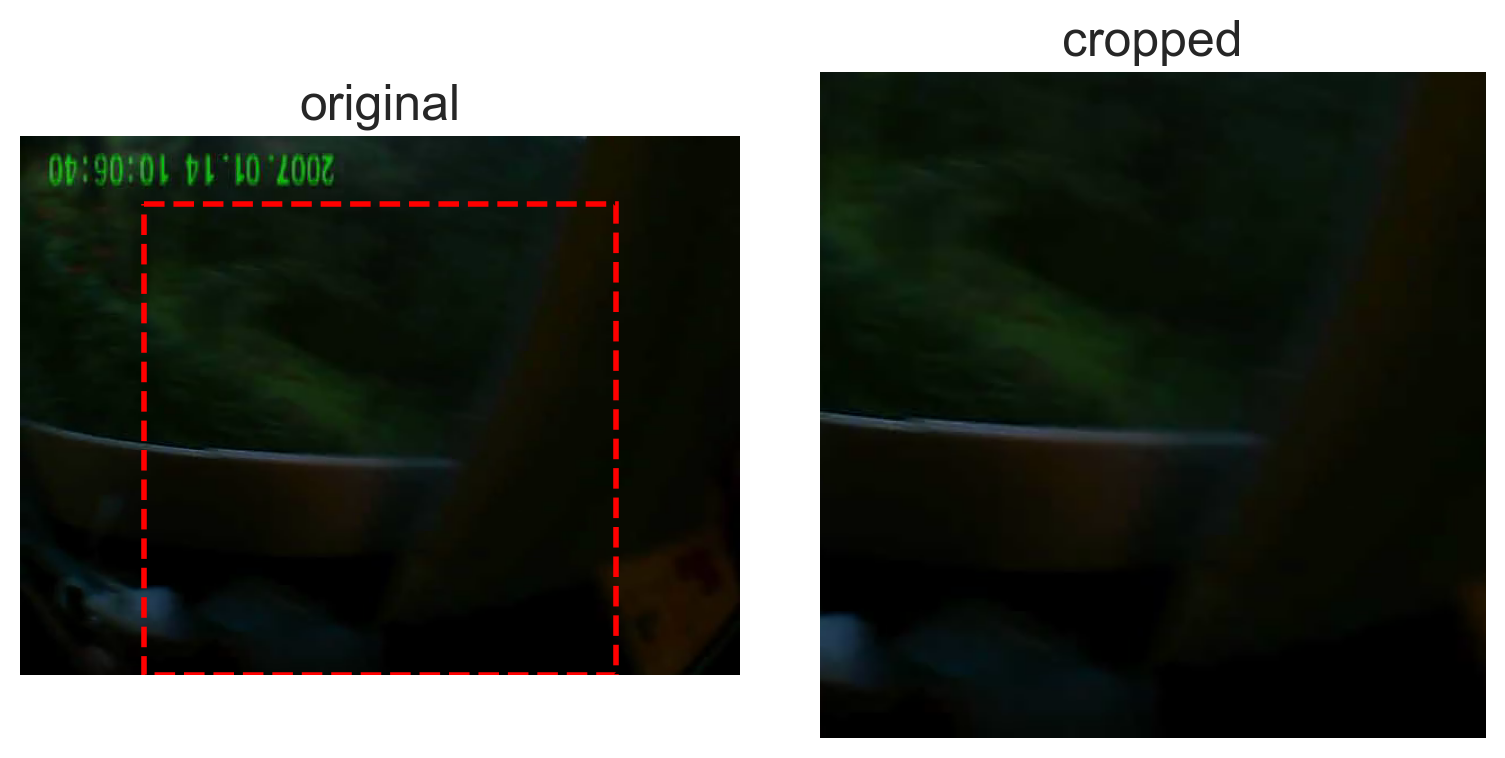

100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


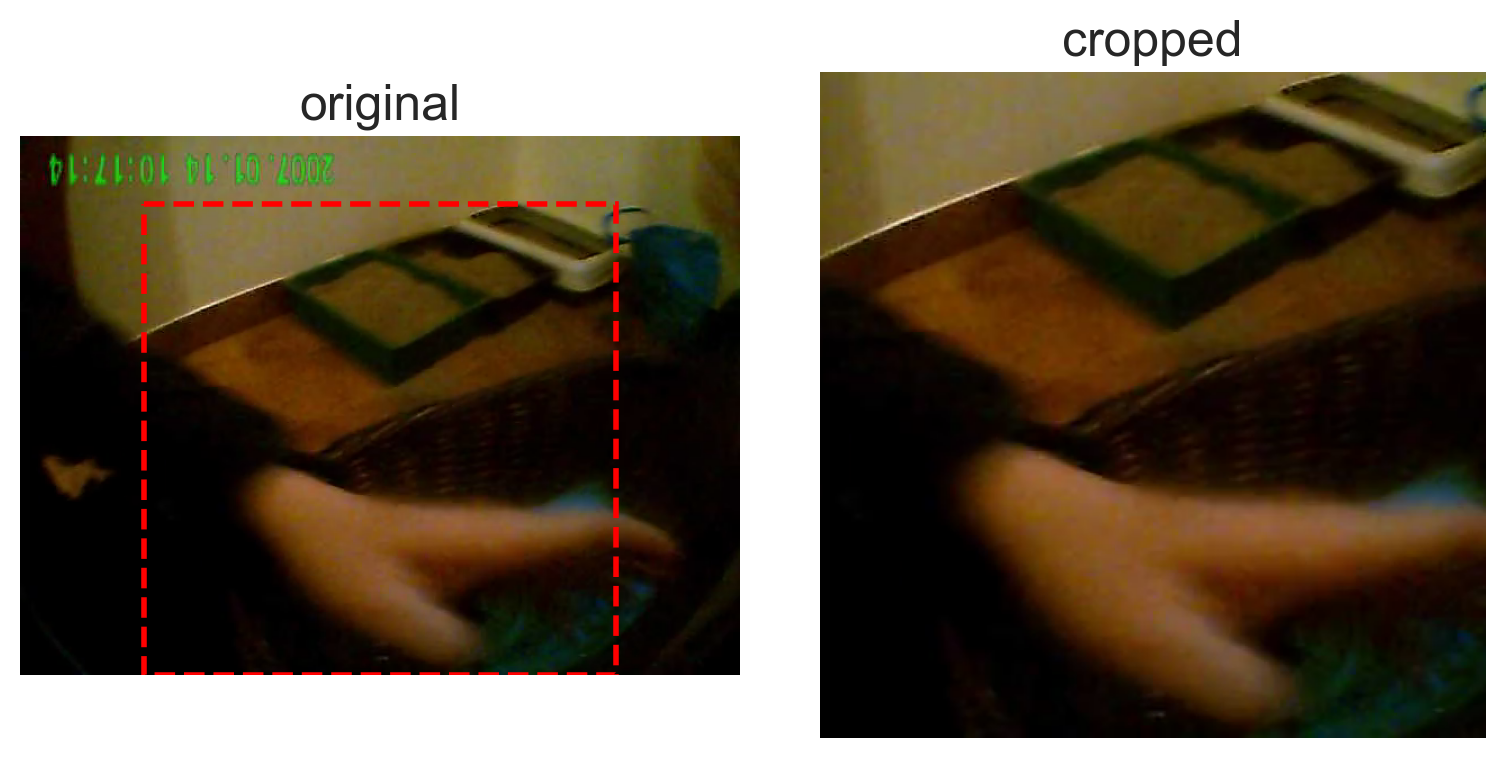

100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


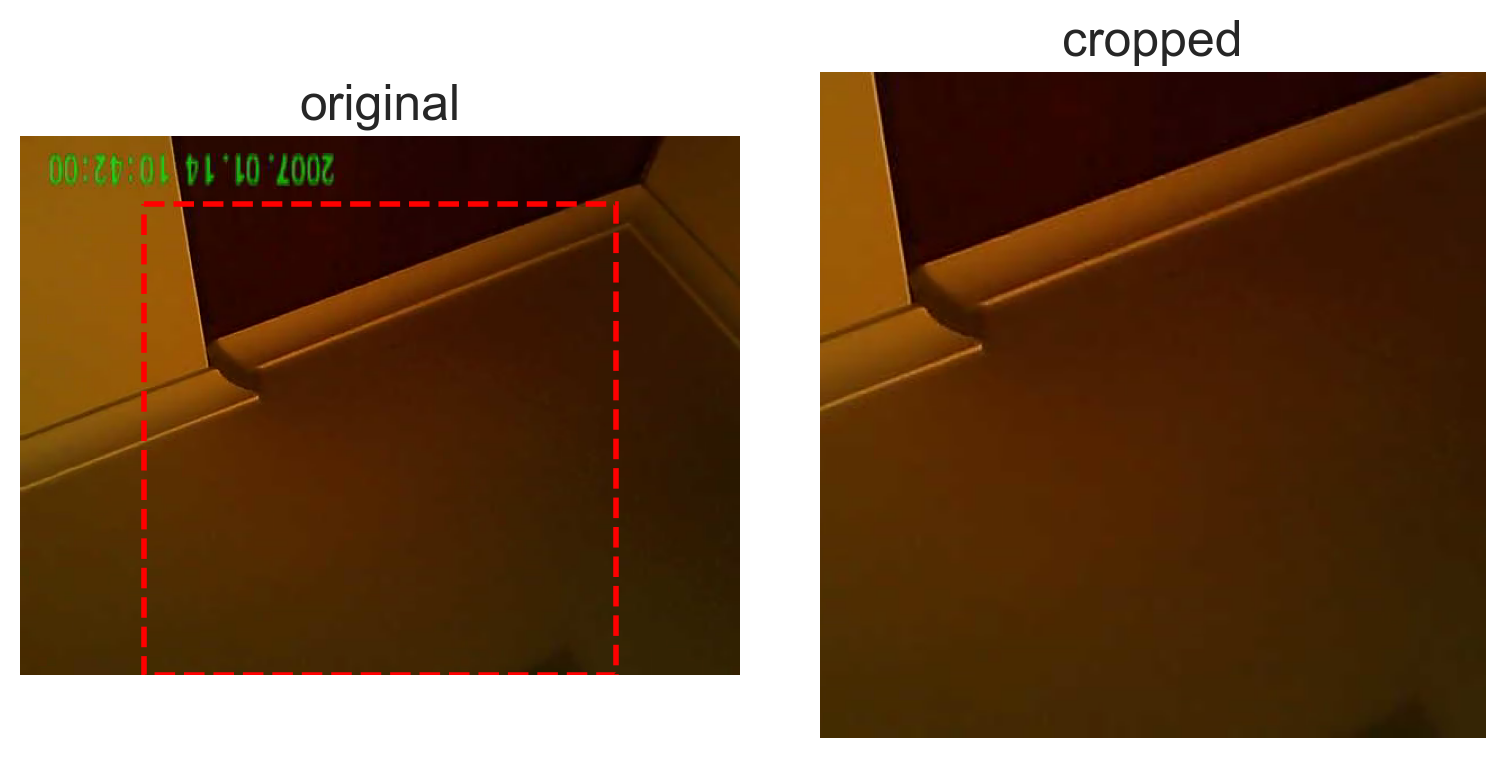

100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


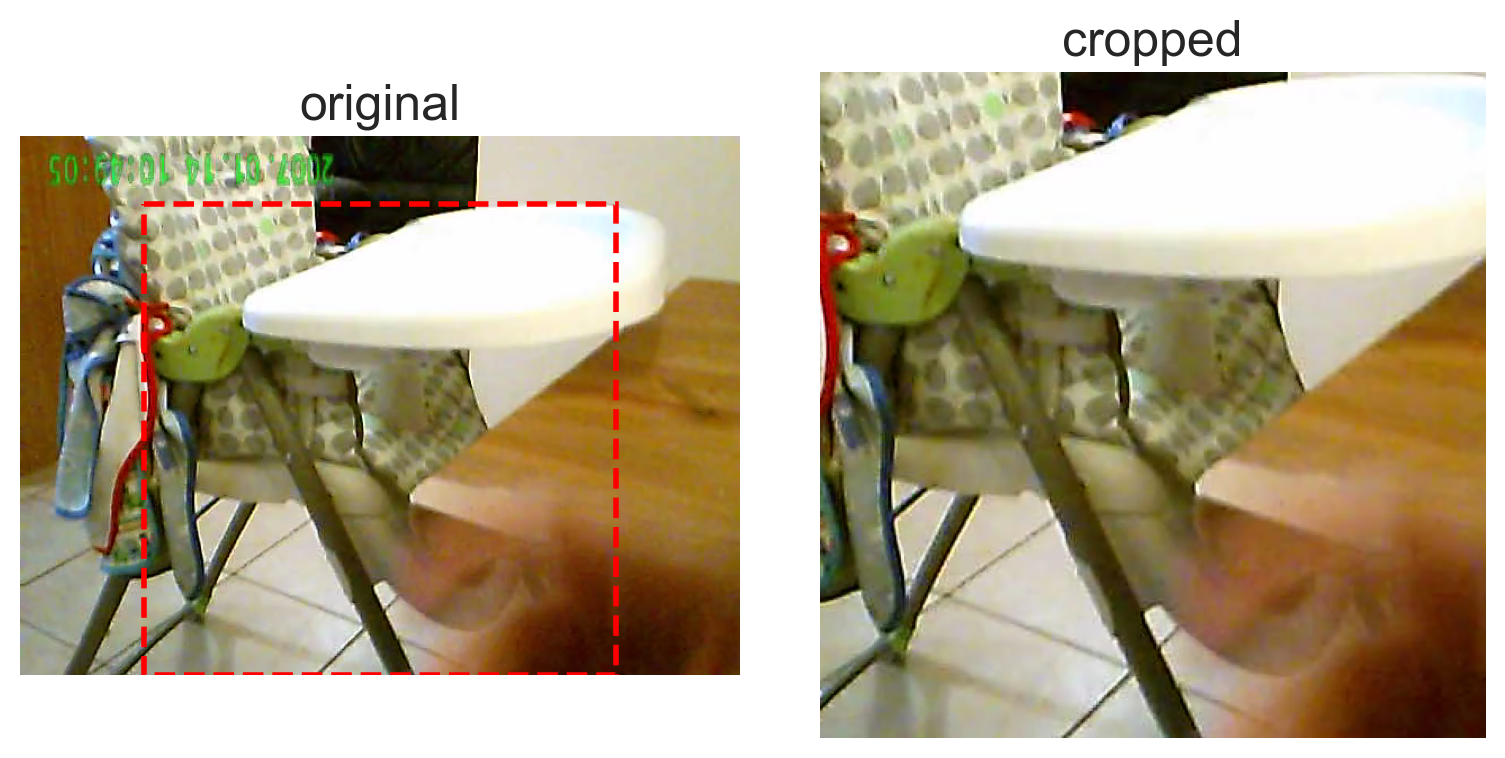

In [12]:
# See example frames (second frame of each video) and the different preprocessing steps
video_paths = sorted(glob.glob(INPUT_DIR + '/**/*.mp4'))

frame_num = 10
for video in video_paths[:min(len(video_paths), 5)]:
    
    frame1 = read_embed_video(video, n_frames=frame_num, preprocess=False)[0][frame_num-1] # gets the second frame
    frame2 = read_embed_video(video, n_frames=frame_num, preprocess=True)[0][frame_num-1]

    cap =  cv2.VideoCapture(video)
    crop_dims = get_cropping_dims(cap)
    cap.release()
    
    plot_frames([cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)[::-1,::-1,:] , frame2], ['original', 'cropped'], 
                crop_dims=crop_dims)

## Model embedding 

Google vision transformer https://huggingface.co/docs/transformers/en/model_doc/vit

Resnet: https://huggingface.co/docs/transformers/en/model_doc/resnet

In [171]:
save_folder = os.path.join(OUTPUT_DIR, 'video_embeddings')

for i,subfolder in enumerate(sorted(os.listdir(INPUT_DIR))):
    subfolder_path = os.path.join(INPUT_DIR, subfolder)

    # each subfolder corresponds to one "video" with multiple video files within to be concatenated
    if os.path.isdir(subfolder_path):

        if os.path.exists(f'{save_folder}/{subfolder}-{MODEL_NAME}.pkl'):
            print(f'File already exists for video {subfolder}, skipping...')

        else:
            print(f'Beginning video {i+1} out of {len(os.listdir(INPUT_DIR))}')
            embeddings, timestamps = read_embed_video(subfolder_path, 
                                        n_frames=None, 
                                        downsampled_frame_rate=DOWNSAMPLED_FR, 
                                        preprocess=True, 
                                        model_name=MODEL_NAME, 
                                        save_folder=save_folder, 
                                        n_jobs=N_JOBS, 
                                        device=DEVICE)
    
            print(f'Saved results to {save_folder}, shape: {embeddings.shape}')
    
# code for saving an entire array with pkl instead:
# pickle_save_dict(embedding_list, outpath)

File already exists for video 33616-S_20131017_1200, skipping...
File already exists for video 33660-S_20131019_1202, skipping...


In [ ]:
if CONCATENATE_ALL:
    all_embeddings_path = f'{OUTPUT_DIR}/video_embeddings/all_embeddings-{MODEL_NAME}.pkl'
    if os.path.exists(all_embeddings_path):
        print('Concatenated file already exists, loading...')
        all_dict = pickle_load_dict(all_embeddings_path)
        all_embeddings = all_dict['embeddings']
        # all_timestamps = all_dict['tiimestamps']
    else:
        # concatenate across all embeddings into one giant thing
        embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*{MODEL_NAME}*.pkl'))
        all_dicts = [pickle_load_dict(e) for e in embeddings_paths]
        all_embeddings, all_timestamps = concatenate_embeddings_timestamps([d['embeddings'] for d in all_dicts], 
                                                            [d['timestamps'] for d in all_dicts],
                                                            downsampled_frame_rate=DOWNSAMPLED_FR,
                                                            save_path = f'{OUTPUT_DIR}/video_embeddings/all_embeddings-{MODEL_NAME}.pkl')

In [ ]:
# how much larger are the videos compared to embeddings?
for model in ['vit', 'resnet']:
    e_to_v_ratios = []
    
    for subfolder in os.listdir(INPUT_DIR):
        embedding_size = os.path.getsize(os.path.join(OUTPUT_DIR, 'video_embeddings', f'{subfolder}-{model}.pkl'))
        sum_vpath_sizes = sum([e.stat().st_size for e in os.scandir(os.path.join(INPUT_DIR, subfolder))])
        e_to_v_ratios.append(embedding_size/sum_vpath_sizes)

    print(f'{model} average embedding-to-video ratio: {np.round(np.mean(e_to_v_ratios), 3)}')

vit average embedding-to-video ratio: 0.029
resnet average embedding-to-video ratio: 0.077


## Raw autocorrelation

In [6]:
# Load embeddings if not already loaded
if CONCATENATE_ALL:
    all_embeddings = pickle_load_dict(OUTPUT_DIR + f'/video_embeddings/all_embeddings-{MODEL_NAME}.pkl')['embeddings']
else:
    all_embeddings = [pickle_load_dict(e)['embeddings'] for e in sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/[!all_embeddings]*{MODEL_NAME}*.pkl'))]

first, we want to look for a power law decay in the autocorrelation function over time

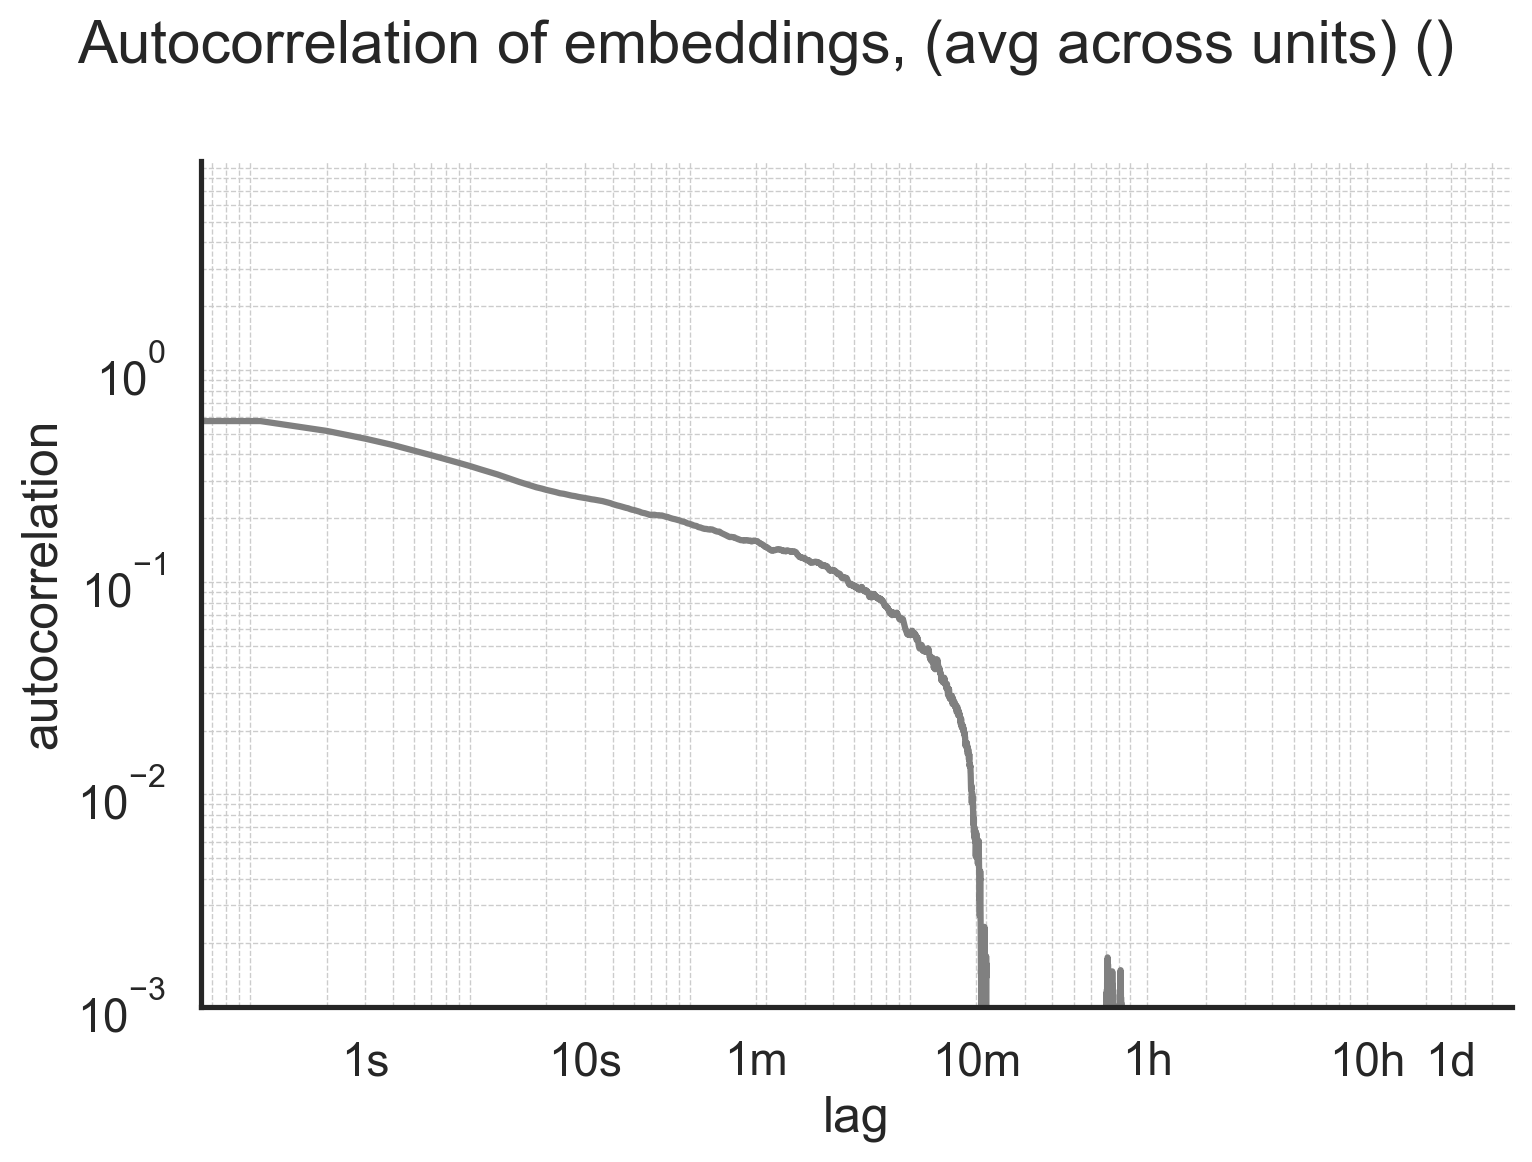

In [7]:
acf_raw_path = OUTPUT_DIR + f'/acf_raw/acfs_all-{MODEL_NAME}.pkl'

if os.path.exists(acf_raw_path):
    acf_data = pickle_load_dict(acf_raw_path)
    plot_acf(**acf_data, plot_ylims=(0.001,None), fpath=f'{OUTPUT_DIR}/acf_raw/acfs_all-cropped-{MODEL_NAME}')
    
else:
    acf_data = run_plot_acf(all_embeddings, permute_n_iter=0, n_jobs=N_JOBS, plot=True, plot_ylims=(1e-7,None),
                            save_folder=OUTPUT_DIR, save_tag=MODEL_NAME)


# default: n = embeddings.shape[0], nlags = n // 2 
# change? to n = 50000, nlags = 20000 

fit power law and exponential function

power law: acf = a * lag^b

exponential: acf = a * b^lag

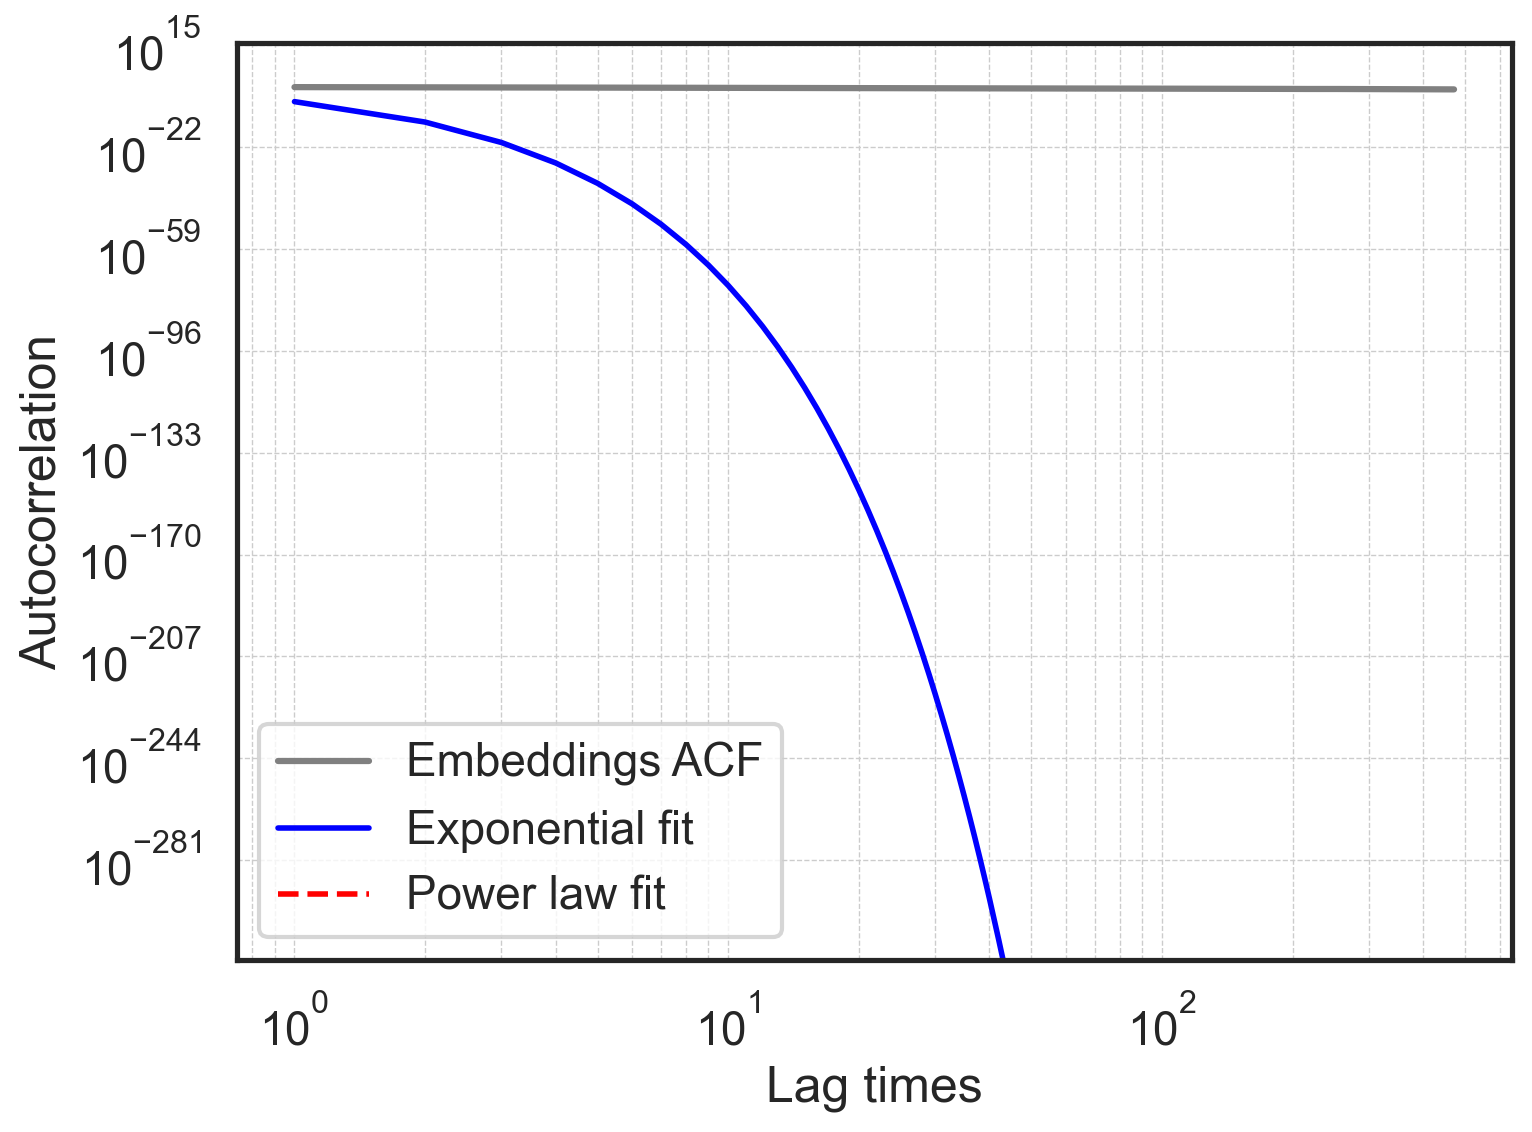

In [81]:
# ATTEMPT 1: SCIPY

from scipy.stats import expon,powerlaw

y_min = 0.1
acfs_limited = acf_data['acfs_all'][0][1:]
acfs_limited = acfs_limited[acfs_limited > y_min]
lag_x = np.arange(1, len(acfs_limited) + 1)  

# fit exponential function
expon_params = expon.fit(acfs_limited)
expon_fitted = expon.pdf(lag_x, *expon_params)

# fit power law function
powerlaw_params = powerlaw.fit(acfs_limited)
powerlaw_fitted = powerlaw.pdf(lag_x, *powerlaw_params)

# Plotting the data and the fits
plt.figure(figsize=(8, 6))
plt.plot(lag_x, acfs_limited, color='gray', label='Embeddings ACF')
plt.plot(lag_x, expon_fitted, label='Exponential fit', color='blue', linewidth=2)
plt.plot(lag_x, powerlaw_fitted, label='Power law fit', color='red', linestyle='--', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lag times')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Calculating best minimal value for power law fit
Power law vs. exponential: R = 1.92, p = 0.25
Power law vs. lognormal: R = -0.00, p = 0.98
Power law vs. truncated_power_law: R = -0.02, p = 0.84
Power law vs. stretched_exponential: R = 0.12, p = 0.77


Assuming nested distributions


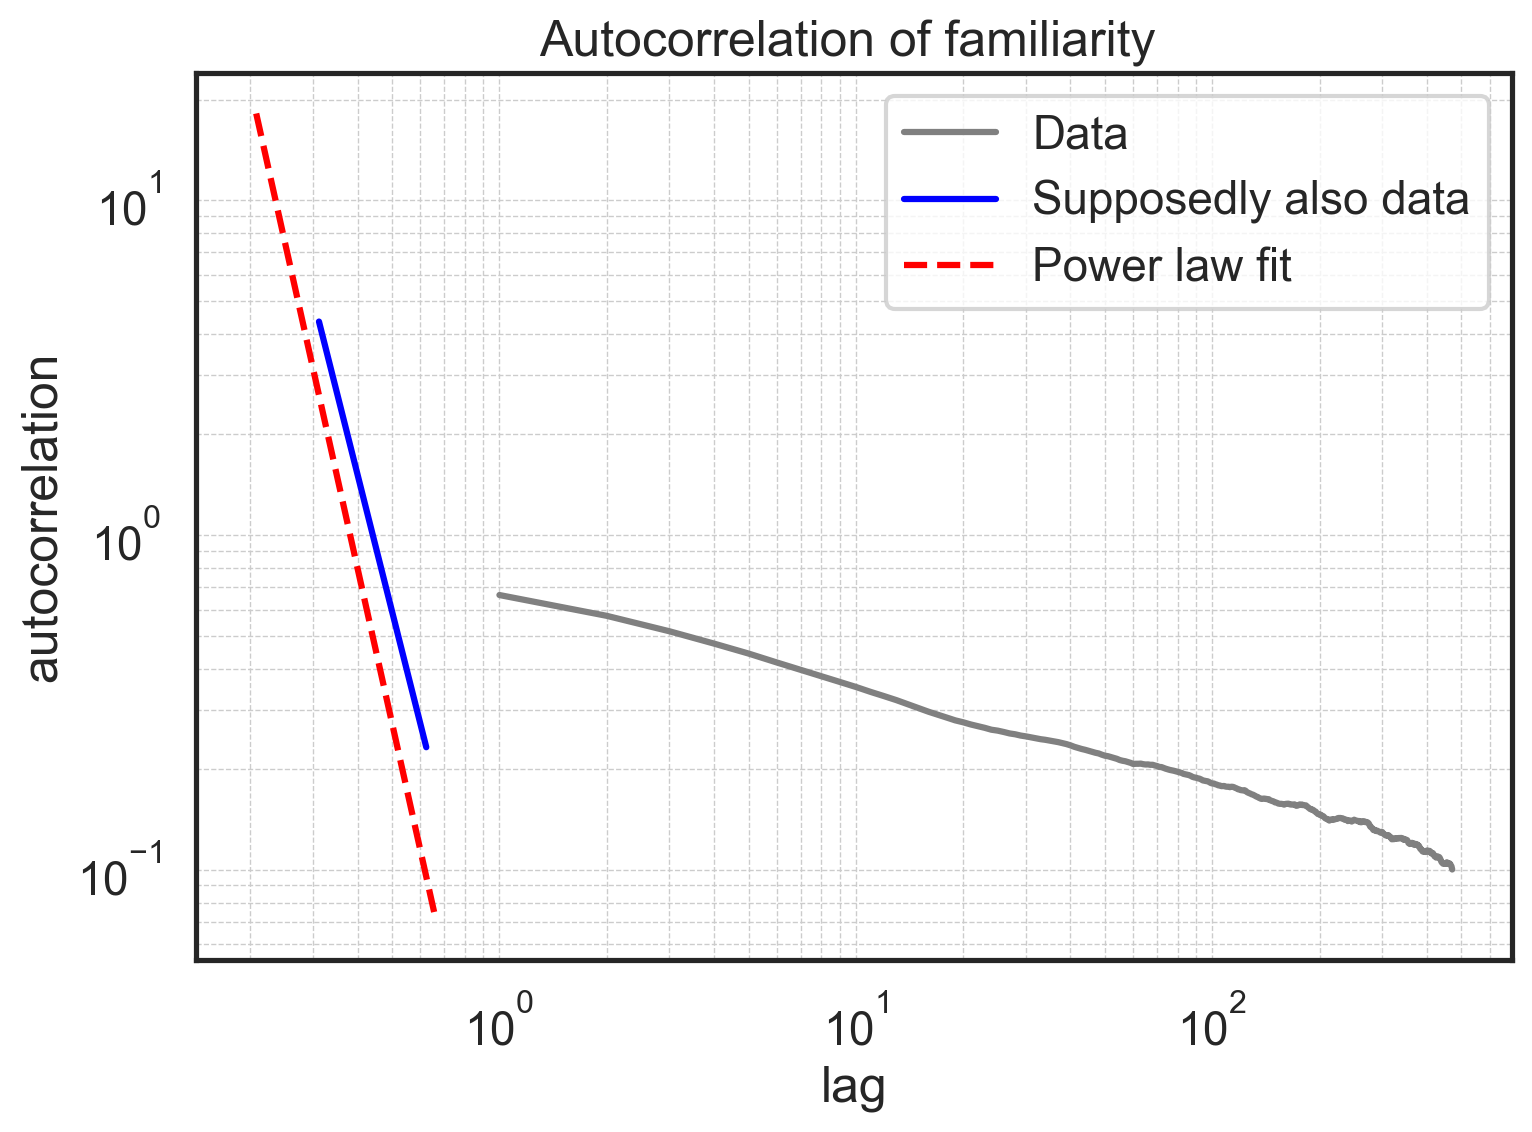

In [111]:
# ATTEMPT 2: POWERLAW PACKAGE

import powerlaw

y_min = 0.1 # cutoff on the y-axis (autocorrelation) to model as powerlaw
acfs_limited = acf_data['acfs_all'][0][1:]
acfs_limited = acfs_limited[acfs_limited > y_min]
lag_x = np.arange(1, len(acfs_limited) + 1)

pl_fit = powerlaw.Fit(acfs_limited)

distributions_to_compare = ['exponential', 'lognormal', 'truncated_power_law', 'stretched_exponential']
for dist in distributions_to_compare:
    R, p = pl_fit.distribution_compare('power_law', dist)
    print(f'Power law vs. {dist}: R = {R:0.02f}, p = {p:0.02f}')

# plot
plt.figure(figsize=(8, 6))
plt.plot(lag_x, acfs_limited, color='gray', label='Data')
pl_fit.plot_pdf(color='blue', label='Supposedly also data')
pl_fit.power_law.plot_pdf(color='red', linestyle='--', label='Power law fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('Autocorrelation of familiarity ')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

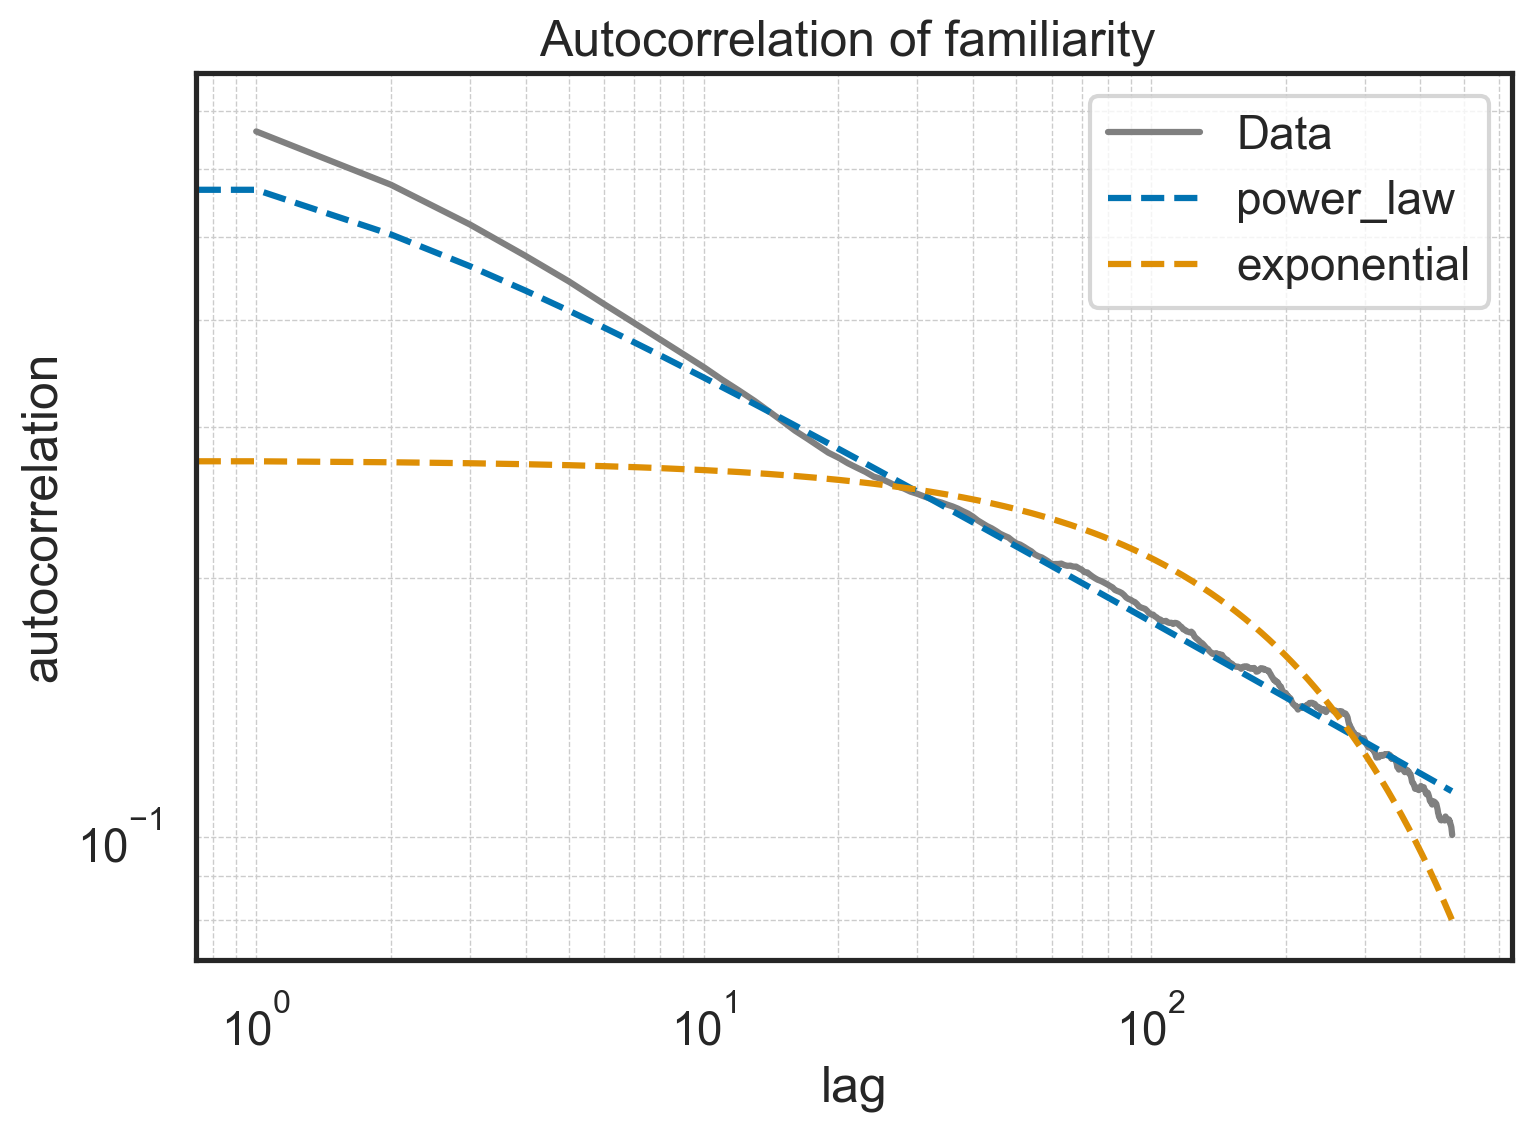

In [ ]:
# ATTEMPT 3: CUSTOM CODE

from scipy.optimize import curve_fit

def fit_acf(acf_data_to_fit, model):
    if model.lower() == 'power_law':
        fit_function = lambda x,a,b: a * x**b
    elif model.lower() == 'exponential':
        fit_function = lambda x,a,b: a * b**x
    elif model.lower() == 'truncated_power_law':
        fit_function = lambda x,a,b,c: a * x**b * c**x
    elif model.lower() == 'stretched_exponential':
        fit_function = lambda x,a,b,c: a * (b * x)**(-c)
    elif model.lower() == 'lognormal':
        fit_function = lambda x,a,b,c: (a / x) * c**(-((np.log(x) - b)**2) / 2)

    x = np.arange(1, len(acf_data_to_fit)+1)
    params, _ = curve_fit(fit_function, x, acf_data_to_fit)
    return fit_function(x, *params)


y_min = 0.1 # cutoff on the y-axis (autocorrelation) to model as powerlaw
acfs_limited = acf_data['acfs_all'][0][1:]
acfs_limited = acfs_limited[acfs_limited > y_min]
lag_x = np.arange(len(acfs_limited))+1

# plot
plt.figure(figsize=(8, 6))
plt.plot(lag_x, acfs_limited, color='gray', label='Data')
distributions_to_compare = ['power_law', 'exponential'] # 'lognormal', 'stretched_exponential', 'truncated_power_law', 
for dist in distributions_to_compare:
    try:
        fit_data = fit_acf(acfs_limited, dist)
        plt.plot(fit_data, linestyle='--', label=dist)
    except:
        print('Failed to fit:', dist)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('Autocorrelation of familiarity ')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Calculate pairwise distances 

In [ ]:
# Load embeddings if not already loaded
if CONCATENATE_ALL:
    all_embeddings = pickle_load_dict(OUTPUT_DIR + f'/video_embeddings/all_embeddings-{MODEL_NAME}.pkl')['embeddings']
else:
    all_embeddings = [pickle_load_dict(e)['embeddings'] for e in sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/[!all_embeddings]*{MODEL_NAME}*.pkl'))]

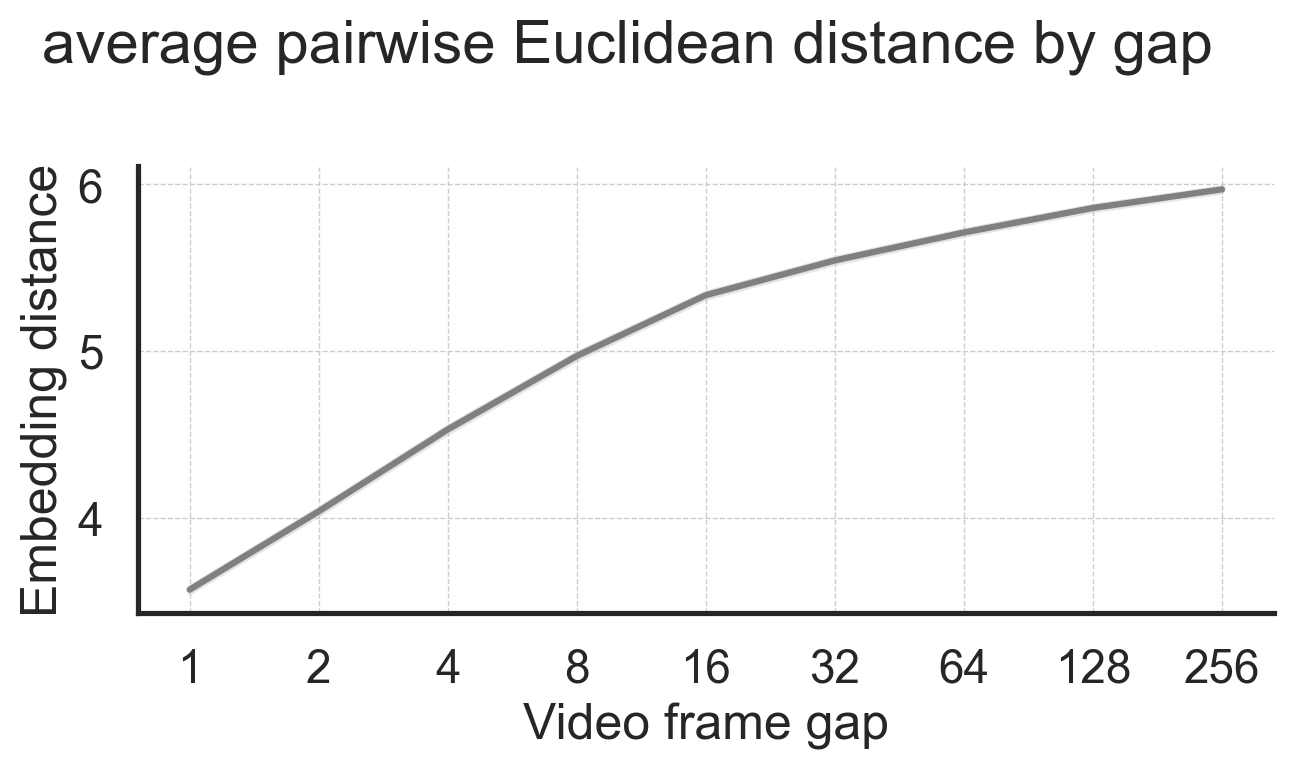

In [366]:
consec_dist_path = OUTPUT_DIR + f'/consec_dist/consec_dist-{MODEL_NAME}.pkl'
if os.path.exists(consec_dist_path):
    consec_dist = pickle_load_dict(consec_dist_path)
    plot_consec_dist(consec_dist), fpath=f'{OUTPUT_DIR}/consec_dist/consec_dist-{MODEL_NAME}')

else: 
    consec_dist = get_consec_dists(all_embeddings, plot=True, save_folder=OUTPUT_DIR, save_tag=MODEL_NAME)

## Familiarity/novelty autocorrelation

now, we will choose a threshold to define familiar vs. novel events (frame embeddings). We will choose a radius (based on the results above of pairwise distances) and take the union of circles around the datapoints to get the "familiarity ball". We will do this ignoring the last <gap> events (WM). Then, events will be marked as either familiar or novel based on their presence in that region.

Finally, we'll compute autocorrelation of that binary vector.

In [ ]:
# Load embeddings if not already loaded
if CONCATENATE_ALL:
    all_embeddings = pickle_load_dict(OUTPUT_DIR + f'/video_embeddings/all_embeddings-{MODEL_NAME}.pkl')['embeddings']
else:
    all_embeddings = [pickle_load_dict(e)['embeddings'] for e in sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/[!all_embeddings]*{MODEL_NAME}*.pkl'))]
    
# load consec_dists if not already loaded
consec_dist = pickle_load_dict(OUTPUT_DIR + f'/consec_dist/consec_dist-{MODEL_NAME}.pkl')

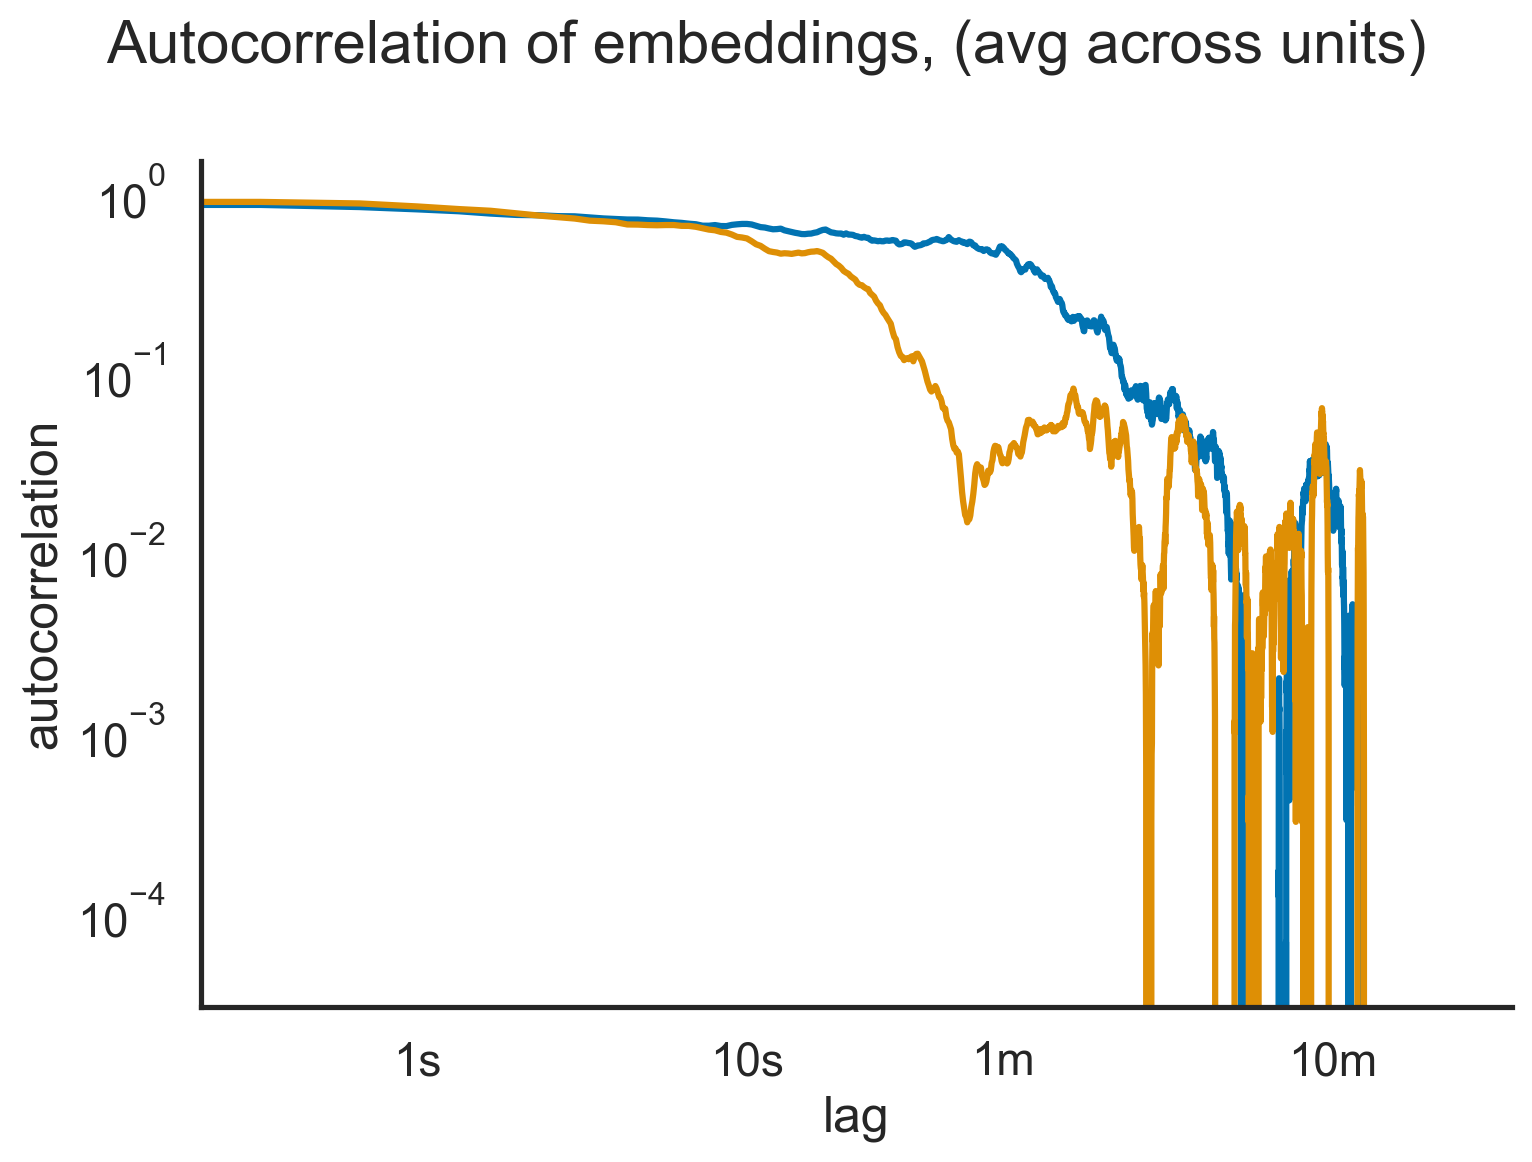

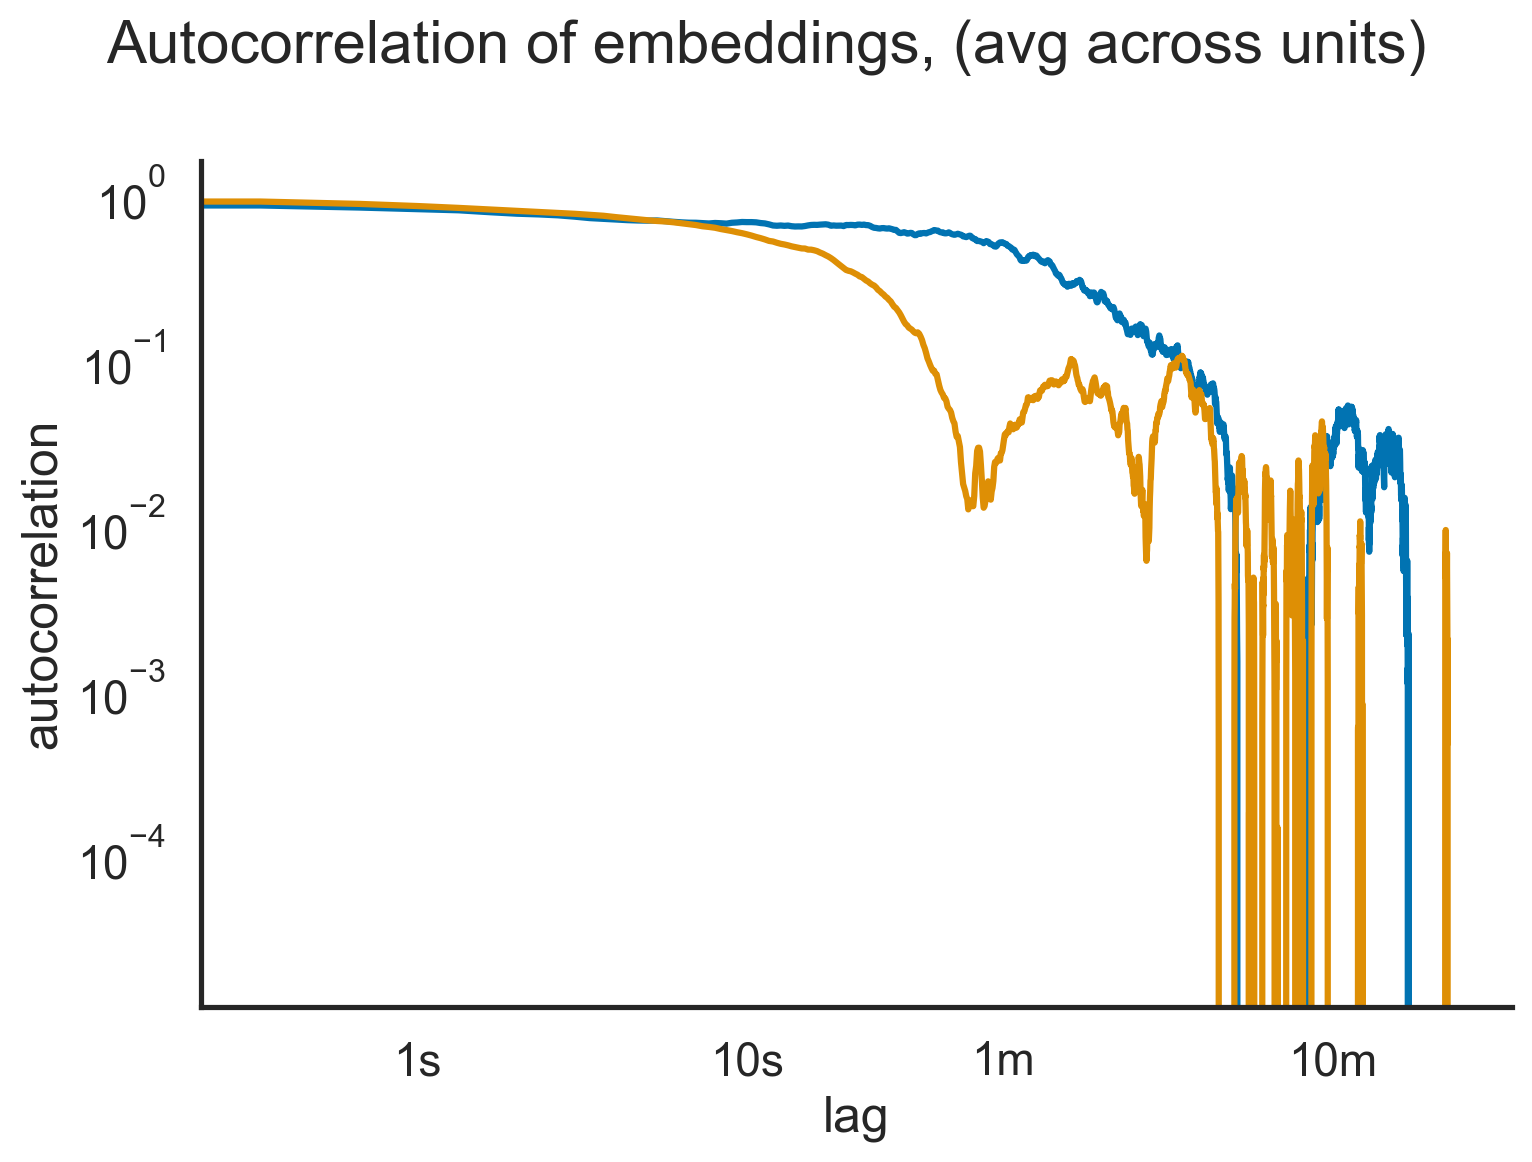

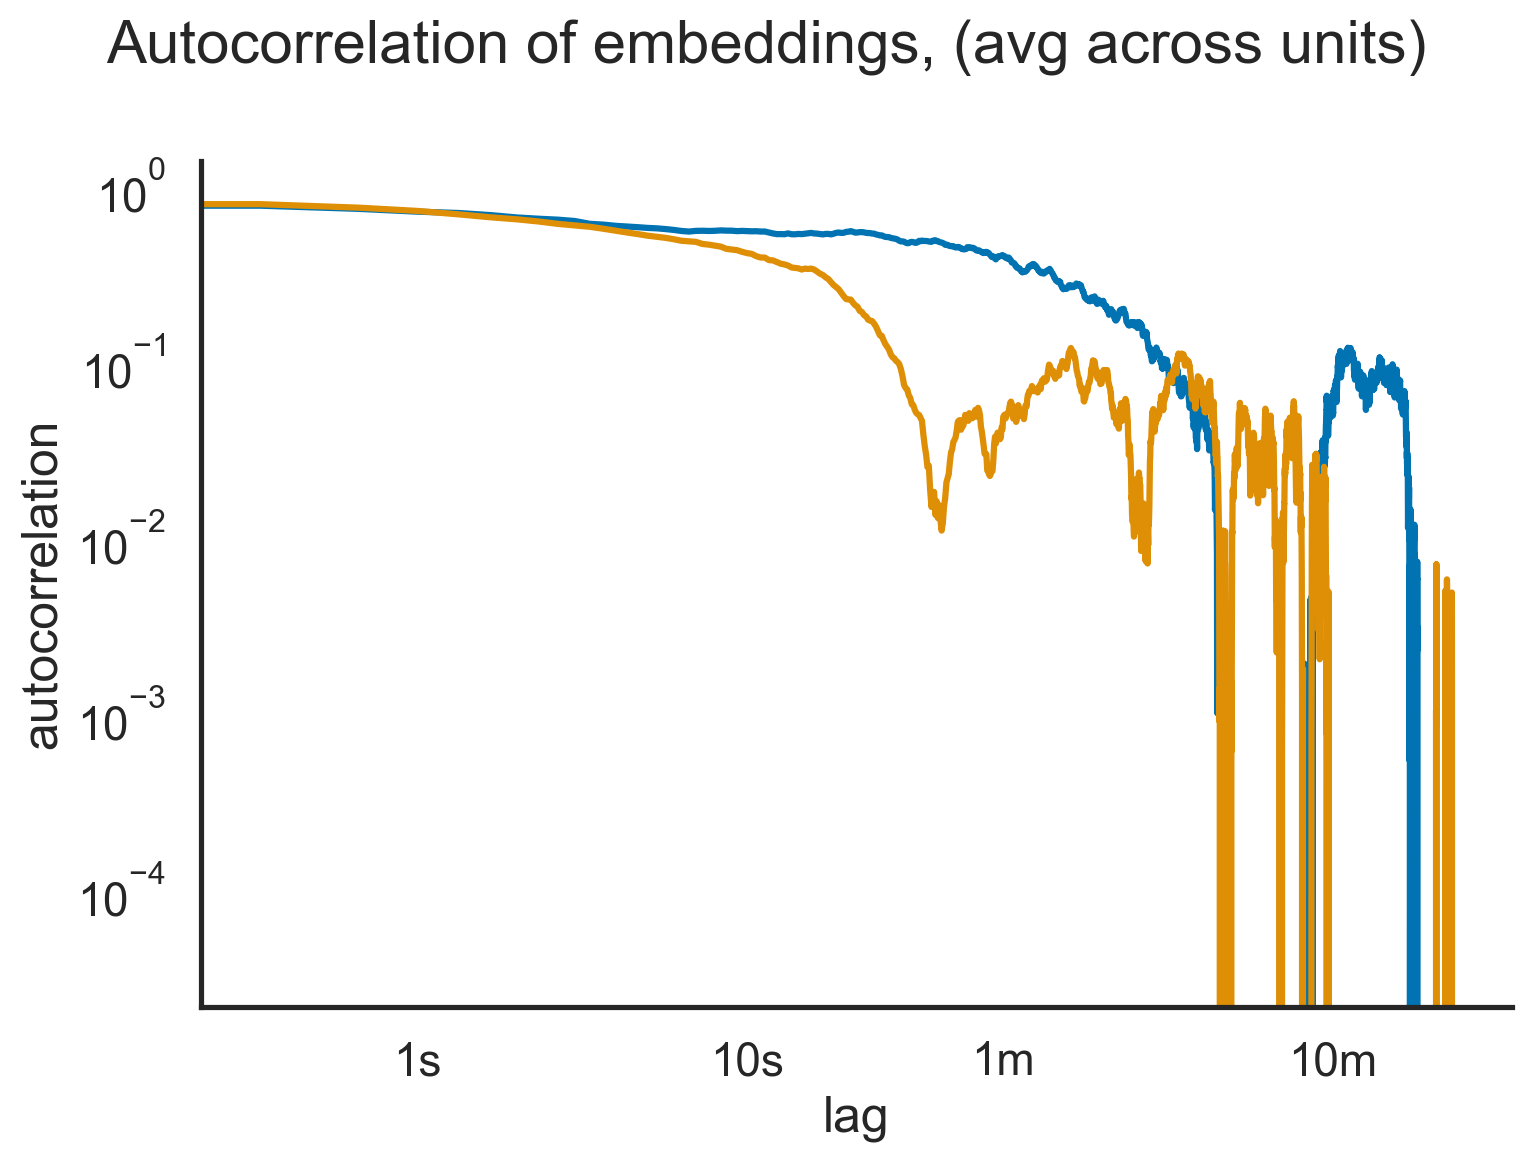

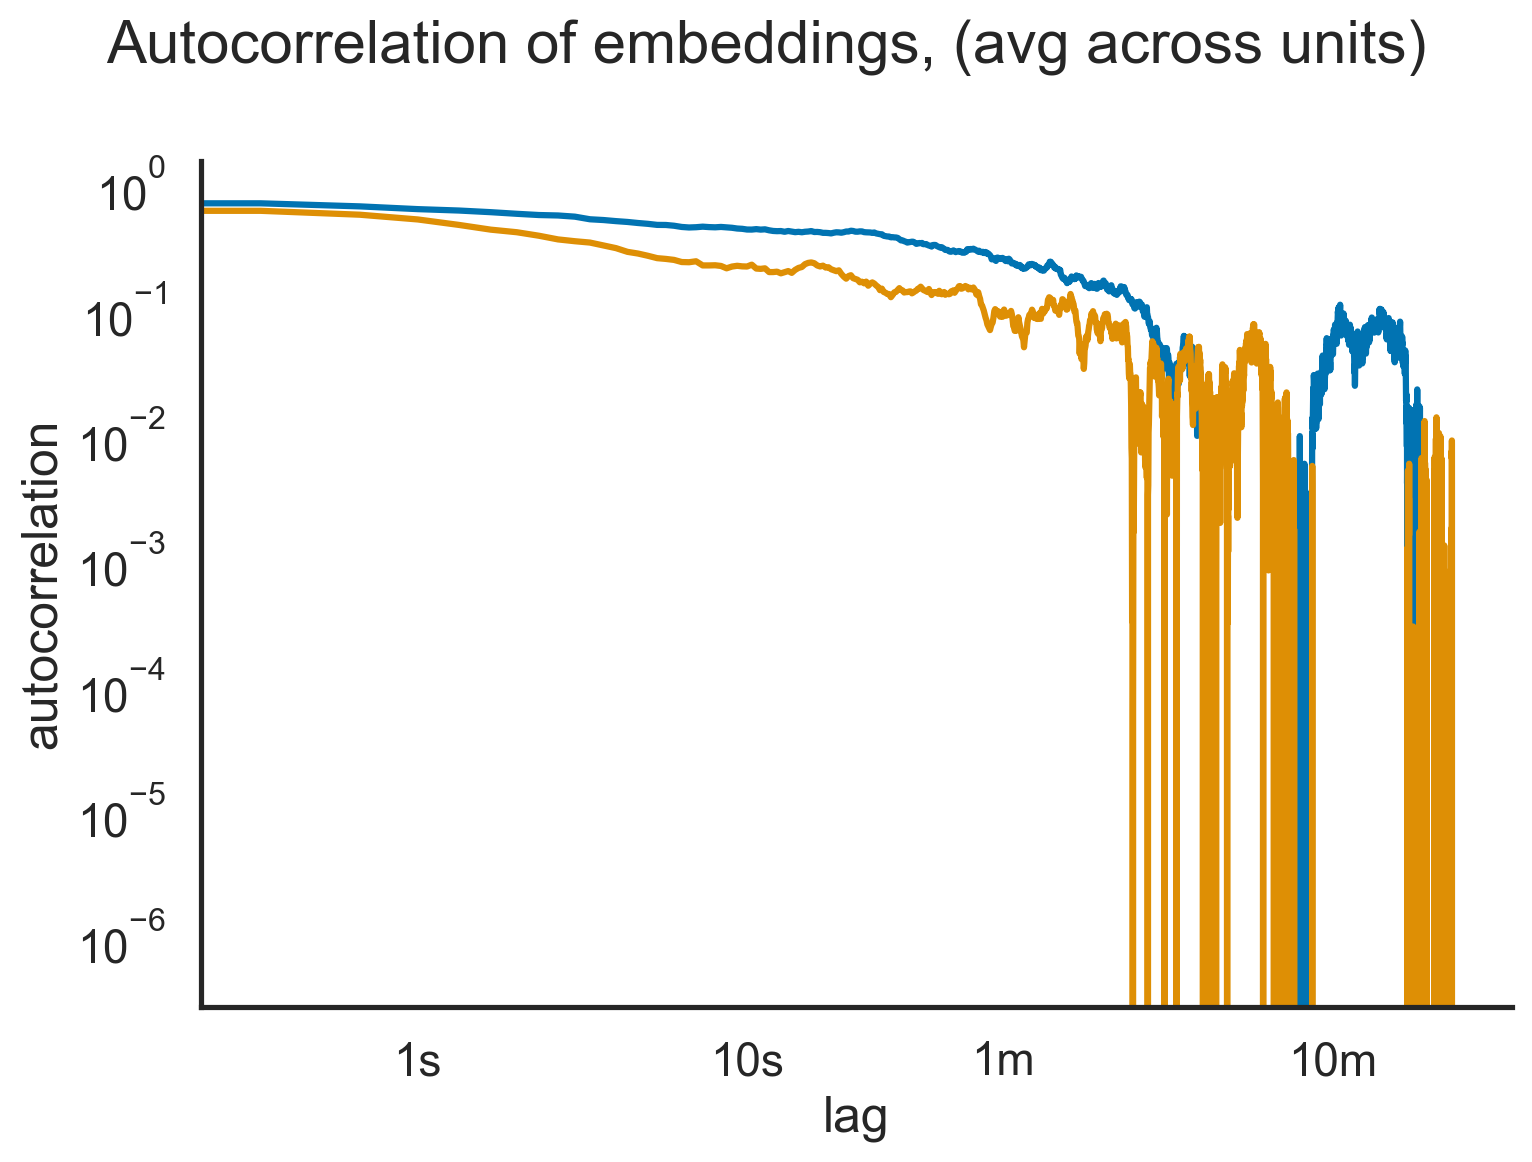

In [ ]:
for gap in [2, 8, 32, 128]:
    acf_fn_path = OUTPUT_DIR + f'/acf_fn/acfs_all-{MODEL_NAME}-gap{gap}.pkl'

    if os.path.exists(acf_fn_path):
        acf_data = pickle_load_dict(acf_fn_path)
        plot_acf(**acf_data)
    
    else:
        familiarity_ts = get_familiarity_timeseries(all_embeddings, consec_dist, gap, n_jobs=N_JOBS)
        _ = run_plot_acf(familiarity_ts, permute_n_iter=PERMUTE_N_ITER, n_jobs=N_JOBS, plot=True, plot_ylims=(1e-7, None),
                         save_folder=OUTPUT_DIR, save_tag = f'{MODEL_NAME}-gap{gap}')
        
    # default: n = embeddings.shape[0], nlags = n // 2 
    # change? to n = 50000, nlags = 20000 

In [ ]:
# def apply_pca(X, n_components=None):
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X)
#     explained_variance_ratio = pca.explained_variance_ratio_
#     return X_pca, explained_variance_ratio, pca

# n_components = dim  # Number of principal components to keep
# X_pca, explained_variance_ratio, pca_model = apply_pca(embeddings, n_components)

# f, ax = plt.subplots(1,1, figsize=(5,4))
# ax.plot(np.cumsum(explained_variance_ratio))
# ax.set_xlabel('# PCs')
# ax.set_ylabel('cum. var. explaiend')
# sns.despine()
# f.tight_layout()
# f, ax = plt.subplots(1,1, figsize=(5,4))
# # ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
# ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(n), cmap='viridis')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# sns.despine()
# f.tight_layout()